In [1]:
using DrWatson
quickactivate(pwd(), "LArAnalysis")
using DelimitedFiles, CairoMakie, Dates

include(srcdir("cal_helpers.jl"));

In [2]:
co_results = custom_parse.(readdlm(datadir("cal_results", "cal_co.txt"); comments=true))
co_results = sortslices(co_results, dims=1)
kr_results = custom_parse.(readdlm(datadir("cal_results", "cal_kr.txt"); comments=true))
kr_results = sortslices(kr_results, dims=1);

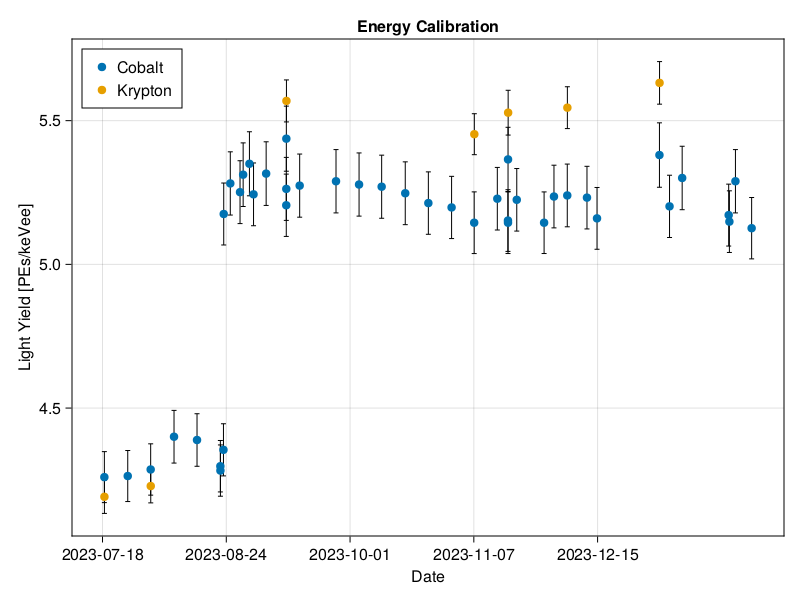

In [3]:
start = datetime2unix(DateTime(2023, 7, 18))
mask = (co_results[:, 2] .> start) .& .~(ismissing.(co_results[:, 3])) .& (co_results[:, 4] .< 1.0)
mask_kr = (kr_results[:, 2] .> start) .& .~(ismissing.(kr_results[:, 3]))
xtic = LinRange(start, datetime2unix(DateTime(2023, 12, 15)), 5)
#xtic = LinRange(start, datetime2unix(now()), 5)
xticd = unix2datetime.(xtic)
xticd = Dates.format.(xticd, "yyyy-mm-dd")
f = Figure()
ax = Axis(f[1, 1], xticks=(xtic, xticd), title="Energy Calibration", ylabel="Light Yield [PEs/keVee]", xlabel="Date")
errorbars!(co_results[:, 2][mask], co_results[:, 3][mask], co_results[:, 4][mask] .* co_results[:, 3][mask], linewidth=1, whiskerwidth=5)
errorbars!(kr_results[:, 2][mask_kr], kr_results[:, 3][mask_kr], kr_results[:, 3][mask_kr] .* kr_results[:, 4][mask_kr], linewidth=1, whiskerwidth=5)
scatter!(co_results[:, 2][mask], co_results[:, 3][mask], label="Cobalt")
scatter!(kr_results[:, 2][mask_kr], kr_results[:, 3][mask_kr], label="Krypton")
axislegend(position=:lt)
f

In [4]:
dt = Dates.format(now(), "yyyymmdd")
save(plotsdir("cal_ly_$dt.png"), f)

CairoMakie.Screen{IMAGE}


## Comparing all calibration methods

In [20]:
using Dates

In [21]:
co_results = custom_parse.(readdlm(datadir("cal_results", "cal_co.txt"); comments=true))
co_results = sortslices(co_results, dims=1)
co_simp_results = custom_parse.(readdlm(datadir("cal_results", "cal_co_simple.txt"); comments=true))
co_simp_results = sortslices(co_simp_results, dims=1)
kr_results = custom_parse.(readdlm(datadir("cal_results", "cal_kr.txt"); comments=true))
kr_results = sortslices(kr_results, dims=1);

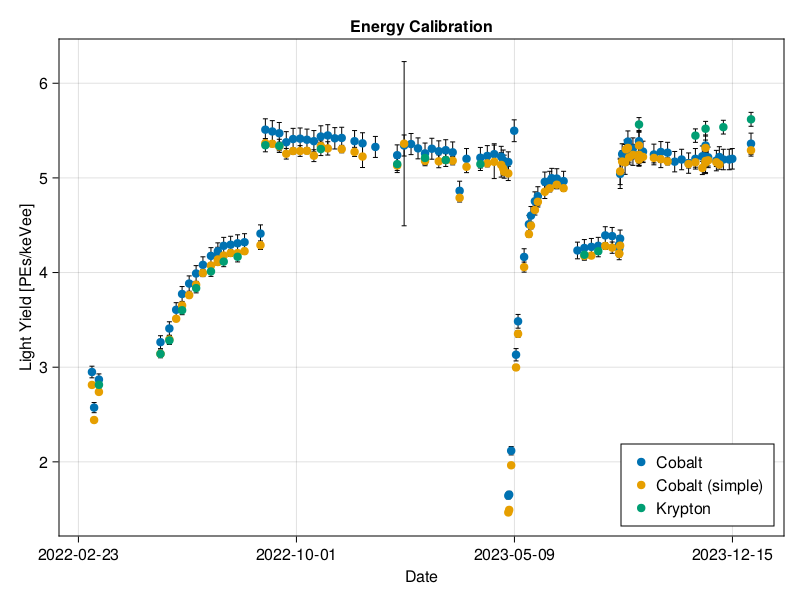

In [29]:
start = datetime2unix(DateTime(2021, 7, 18))
mask = (co_results[:, 2] .> start) .& .~(ismissing.(co_results[:, 3])) .& (co_results[:, 4] .< 1.0)
mask_sim = (co_simp_results[:, 2] .> start) .& .~(ismissing.(co_simp_results[:, 3])) .& (co_simp_results[:, 4] .< 1.0)
mask_kr = (kr_results[:, 2] .> start) .& .~(ismissing.(kr_results[:, 3]))
xtic = LinRange(start, datetime2unix(DateTime(2023, 12, 15)), 5)
#xtic = LinRange(start, datetime2unix(now()), 5)
xticd = unix2datetime.(xtic)
xticd = Dates.format.(xticd, "yyyy-mm-dd")
f = Figure()
ax = Axis(f[1, 1], xticks=(xtic, xticd), title="Energy Calibration", ylabel="Light Yield [PEs/keVee]", xlabel="Date")
errorbars!(co_results[:, 2][mask], co_results[:, 3][mask], co_results[:, 4][mask] .* co_results[:, 3][mask], linewidth=1, whiskerwidth=5)
errorbars!(co_simp_results[:, 2][mask_sim], co_simp_results[:, 3][mask_sim], co_simp_results[:, 4][mask_sim] .* co_simp_results[:, 3][mask_sim], linewidth=1, whiskerwidth=5)
errorbars!(kr_results[:, 2][mask_kr], kr_results[:, 3][mask_kr], kr_results[:, 3][mask_kr] .* kr_results[:, 4][mask_kr], linewidth=1, whiskerwidth=5)
scatter!(co_results[:, 2][mask], co_results[:, 3][mask], label="Cobalt")
scatter!(co_simp_results[:, 2][mask_sim], co_simp_results[:, 3][mask_sim], label="Cobalt (simple)")
scatter!(kr_results[:, 2][mask_kr], kr_results[:, 3][mask_kr], label="Krypton")
axislegend(position=:rb)
f


## Space to explore individual calibration runs

In [12]:
using DrWatson
quickactivate(pwd(), "LArAnalysis")
using UnROOT, FHist, LsqFit, DelimitedFiles, CairoMakie, Printf, Distributions, Optim, LArCal

┌ Warning: Module UnROOT with build ID ffffffff-ffff-ffff-0000-b1cebea92a10 is missing from the cache.
│ This may mean UnROOT [3cd96dde-e98d-4713-81e9-a4a1b0235ce9] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1793


In [13]:
const kr_energy = 41.55
function calkrypton_test(krypton_file)
  rf = ROOTFile(krypton_file)
  t = LazyTree(rf, "SimOut", ["adc1", "adc3", "f90", "timestamp", "runno"])

  run = t.runno[1]
  timestamp = t.timestamp[1]

  bkg_fl = readdir(datadir("exp_pro"); join=true)
  bkg_fl = filter(x -> occursin("Bkg", x), bkg_fl)
  bkg_rn = parse.(Int, (map(x -> x.match, match.(r"[0-9]+", bkg_fl))))
  Δrun = abs.(bkg_rn .- run)
  close_bkg = bkg_fl[argmin(Δrun)]
  bkg_f = ROOTFile(close_bkg)
  bkgt = LazyTree(bkg_f, "SimOut", ["adc1", "adc3", "f90", "timestamp"])

  timestamp_bkg = bkgt.timestamp[1]

  adc1 = t.adc1 |> collect
  adc3 = t.adc3 |> collect
  f90 = t.f90 |> collect
  adc_bkg1 = bkgt.adc1 |> collect
  adc_bkg3 = bkgt.adc3 |> collect
  f90_bkg = bkgt.f90 |> collect

  spe = readdlm(datadir("cal_results", "spe.txt"); comments=true)
  spekr_i = argmin(abs.(spe[:, 1] .- timestamp))
  spebkg_i = argmin(abs.(spe[:, 1] .- timestamp_bkg))
  spekr1, spekr3 = spe[spekr_i, 2:3]
  spebkg1, spebkg3 = spe[spebkg_i, 2:3]

  # Run times for scaling
  kr_time = t.timestamp[end] - t.timestamp[1]
  bkg_time = bkgt.timestamp[end] - bkgt.timestamp[1]

  npe_kr = adc1 ./ spekr1 .+ adc3 ./ spekr3
  npe_bkg = adc_bkg1 ./ spebkg1 .+ adc_bkg3 ./ spebkg3

  mask = (f90 .< 0.4) .& (f90 .> 0.1)
  mask_bkg = (f90_bkg .< 0.4) .& (f90_bkg .> 0.1)
  bins = range(60, 400, length=120)
  kr_hist = Hist1D(npe_kr[mask], bins)
  bkg_hist = Hist1D(npe_bkg[mask_bkg], bins)

  data = kr_hist - bkg_hist * (kr_time / bkg_time)
  display(hist(data))
  low, high = extrema(bincounts(data))
  @show low high
  if high > 100.0
    idx = argmax(bincounts(data))
    kr_fit = curve_fit(gaus, bincenters(data), bincounts(data), [1e4, bins[idx], 10.0])
    _, μ, σ = coef(kr_fit)
    _, μerr, _ = stderror(kr_fit)
    resolution = abs(σ / μ)
    lightyield = μ / kr_energy
    err = sqrt((μerr / μ)^2 + spe[spekr_i, 4]^2)

    return run, timestamp, lightyield, err, resolution
  else
    println("No krypton data above background")
    return run, timestamp, missing, missing, missing
  end
end


calkrypton_test (generic function with 1 method)

In [23]:
const kr_energy = 41.55
function calkrypton_test_wtop(krypton_file)
  rf = ROOTFile(krypton_file)
  t = LazyTree(rf, "SimOut", ["adc1", "adc3", "f90", "timestamp", "runno", "light_fraction"])

  run = t.runno[1]
  timestamp = t.timestamp[1]

  bkg_fl = readdir(datadir("exp_pro"); join=true)
  bkg_fl = filter(x -> occursin("Bkg", x), bkg_fl)
  bkg_rn = parse.(Int, (map(x -> x.match, match.(r"[0-9]+", bkg_fl))))
  Δrun = abs.(bkg_rn .- run)
  close_bkg = bkg_fl[argmin(Δrun)]
  bkg_f = ROOTFile(close_bkg)
  bkgt = LazyTree(bkg_f, "SimOut", ["adc1", "adc3", "f90", "timestamp"])

  timestamp_bkg = bkgt.timestamp[1]

  adc1 = t.adc1 |> collect
  adc3 = t.adc3 |> collect
  f90 = t.f90 |> collect
  top = t.light_fraction |> collect
  adc_bkg1 = bkgt.adc1 |> collect
  adc_bkg3 = bkgt.adc3 |> collect
  f90_bkg = bkgt.f90 |> collect

  spe = readdlm(datadir("cal_results", "spe.txt"); comments=true)
  spekr_i = argmin(abs.(spe[:, 1] .- timestamp))
  spebkg_i = argmin(abs.(spe[:, 1] .- timestamp_bkg))
  spekr1, spekr3 = spe[spekr_i, 2:3]
  spebkg1, spebkg3 = spe[spebkg_i, 2:3]

  # Run times for scaling
  kr_time = t.timestamp[end] - t.timestamp[1]
  bkg_time = bkgt.timestamp[end] - bkgt.timestamp[1]

  npe_kr = adc1 ./ spekr1 .+ adc3 ./ spekr3
  npe_bkg = adc_bkg1 ./ spebkg1 .+ adc_bkg3 ./ spebkg3

  mask = (f90 .< 0.4) .& (f90 .> 0.1) .& (top .< 0.6) .& (top .> 0.4)
  mask_bkg = (f90_bkg .< 0.4) .& (f90_bkg .> 0.1)
  bins = range(60, 400, length=120)
  kr_hist = Hist1D(npe_kr[mask], bins)
  bkg_hist = Hist1D(npe_bkg[mask_bkg], bins)

  data = kr_hist - bkg_hist * (kr_time / bkg_time)
  display(hist(data))
  low, high = extrema(bincounts(data))
  @show low high
  if argmax(bincounts(data)) > 15
    idx = argmax(bincounts(data))
    kr_fit = curve_fit(gaus, bincenters(data), bincounts(data), [1e4, bins[idx], 10.0])
    _, μ, σ = coef(kr_fit)
    _, μerr, _ = stderror(kr_fit)
    resolution = abs(σ / μ)
    lightyield = μ / kr_energy
    err = sqrt((μerr / μ)^2 + spe[spekr_i, 4]^2)

    return run, timestamp, lightyield, err, resolution
  else
    println("No krypton data above background")
    return run, timestamp, missing, missing, missing
  end
end


calkrypton_test_wtop (generic function with 1 method)

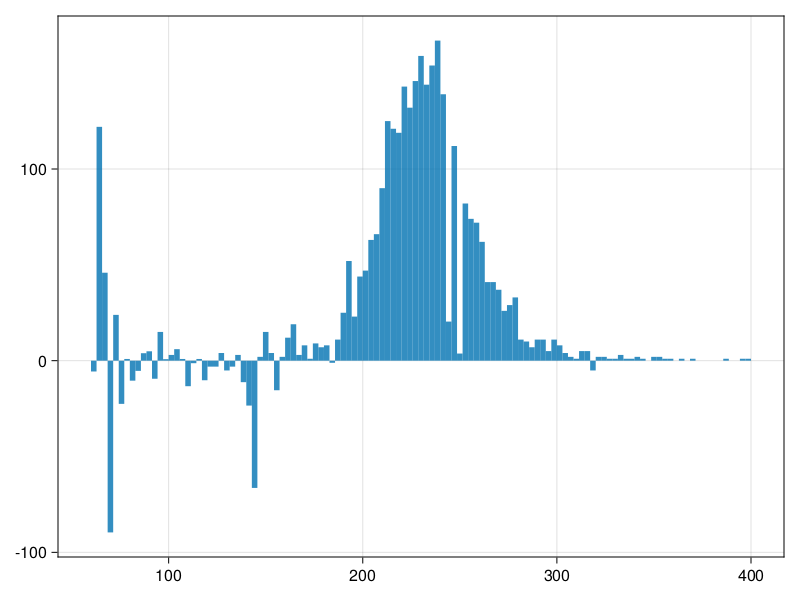

low = -89.6
high = 167.0
calkrypton_test(krypton_fl[1]) = (1409903, 1.700256768e9, 5.518845852178126, 0.014089759034559814, 0.09040097610038884)


(1409903, 1.700256768e9, 5.518845852178126, 0.014089759034559814, 0.09040097610038884)

In [19]:
krypton_fl = readdir(datadir("exp_pro"); join=true)
krypton_fl = filter(x -> occursin("Krypton_1409", x), krypton_fl)
@show calkrypton_test(krypton_fl[1])

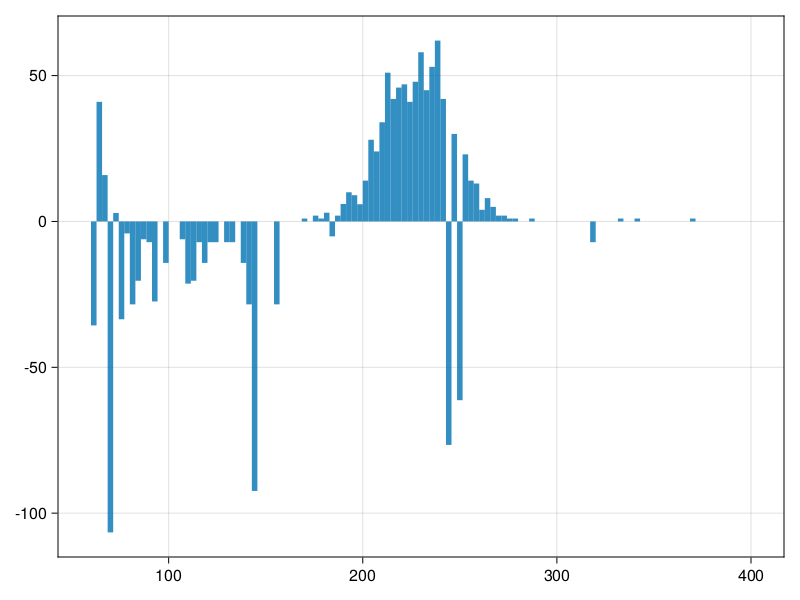

low = -106.6
high = 62.0
calkrypton_test_wtop(krypton_fl[1]) = (1409903, 1.700256768e9, 5.368001783705619, 0.016667565149845964, 0.057237793419684185)


(1409903, 1.700256768e9, 5.368001783705619, 0.016667565149845964, 0.057237793419684185)

In [24]:
@show calkrypton_test_wtop(krypton_fl[1])

In [ ]:
cobalt_fl = readdir(datadir("exp_pro"); join=true)
cobalt_fl = filter(x -> occursin("Cobalt_1402797", x), cobalt_fl)
@show calcobalt(cobalt_fl[1])

In [ ]:
cobalt_fl = readdir(datadir("exp_pro"); join=true)
cobalt_fl = filter(x -> occursin("Cobalt", x), cobalt_fl)
for f in cobalt_fl
  @show calcobalt(f)
end

## Space for looking at new algorithms

In [ ]:
using DrWatson
quickactivate(pwd(), "LArAnalysis")
using UnROOT, FHist, LsqFit, DelimitedFiles, CairoMakie, Printf, Distributions, BlackBoxOptim, LArCal

In [ ]:
const sim_ly = 4.75 # PE/keVee
const co_energy = 122.0 # keV

function calcobalt_test(cobalt_file)
  rf = ROOTFile(cobalt_file)
  t = LazyTree(rf, "SimOut", ["adc1", "adc3", "timestamp", "runno"])

  run = t.runno[1]
  timestamp = t.timestamp[1]

  bkg_fl = readdir(datadir("exp_pro"); join=true)
  bkg_fl = filter(x -> occursin("Bkg", x), bkg_fl)
  bkg_rn = parse.(Int, (map(x -> x.match, match.(r"[0-9]+", bkg_fl))))
  Δrun = abs.(bkg_rn .- run)
  close_bkg = bkg_fl[argmin(Δrun)]
  bkg_f = ROOTFile(close_bkg)
  bkgt = LazyTree(bkg_f, "SimOut", ["adc1", "adc3", "timestamp"])

  timestamp_bkg = bkgt.timestamp[1]

  adc1 = t.adc1 |> collect
  replace!(x -> x > 1e6 ? 0.0 : x, adc1) # replace bad samples
  adc3 = t.adc3 |> collect
  replace!(x -> x > 1e6 ? 0.0 : x, adc3) # replace bad samples
  adc_bkg1 = bkgt.adc1 |> collect
  replace!(x -> x > 1e6 ? 0.0 : x, adc_bkg1) # replace bad samples
  adc_bkg3 = bkgt.adc3 |> collect
  replace!(x -> x > 1e6 ? 0.0 : x, adc_bkg3) # replace bad samples

  spe = readdlm(datadir("cal_results", "spe.txt"); comments=true)
  speco_i = argmin(abs.(spe[:, 1] .- timestamp))
  spebkg_i = argmin(abs.(spe[:, 1] .- timestamp_bkg))
  speco1, speco3 = spe[speco_i, 2:3]
  spebkg1, spebkg3 = spe[spebkg_i, 2:3]

  # Run times for scaling
  co_time = t.timestamp[end] - t.timestamp[1]
  bkg_time = bkgt.timestamp[end] - bkgt.timestamp[1]

  npe_co = adc1 ./ speco1 .+ adc3 ./ speco3 |> filter(isfinite)
  npe_bkg = adc_bkg1 ./ spebkg1 .+ adc_bkg3 ./ spebkg3 |> filter(isfinite)
  if any(isnan, npe_co) || any(isnan, npe_bkg)
    println("Skipping Run $run")
    return run, timestamp, missing, missing, missing
  end

  sim_pe = readdlm(datadir("sims", "cobalt_cal.txt"))

  # Ranges of possible LYs to search for
  yields = range(1.5, 5.5, length=40)
  bins = range(10, 800, length=200)
  co_hist = Hist1D(npe_co, bins)
  bkg_hist = Hist1D(npe_bkg, bins)
  sim_hist = Hist1D(sim_pe ./ sim_ly, bins)

  data = co_hist - bkg_hist * (co_time / bkg_time)
  σs = sqrt.(abs.(bincounts(data)))
  function L(θ)
    sc_hist = Hist1D(sim_pe ./ θ, bins)
    sc_sim = sc_hist * (integral(data) / integral(sc_hist))
    resid = data - sc_sim |> bincounts
    ll = -log.(pdf.(Normal.(0.0, σs), resid)) |> filter(isfinite)
    sum(ll)
    # sum(-logpdf.(Normal.(0.0, σs), resid) |> filter(isfinite))
  end
  lys = range(1.5, 5.5, length=40)
  L.(lys)

  # lower = 1.5
  # upper = 5.5
  # res = bboptimize(L; SearchRange=[(1.5, 5.5)])
  # ly_best = Optim.minimizer(res)

  # run, timestamp, ly_best, ly_best * co_energy
end

In [ ]:
cobalt_fl = readdir(datadir("exp_pro"); join=true)
cobalt_fl = filter(x -> occursin("Cobalt_1402797", x), cobalt_fl)
res = calcobalt_test(cobalt_fl[1])
scatter(range(1.5, 5.5, length=40), res)

In [ ]:
const sim_ly = 4.75 # PE/keVee
const co_energy = 122.0 # keV

function calcobalt_test2(cobalt_file)
  rf = ROOTFile(cobalt_file)
  t = LazyTree(rf, "SimOut", ["adc1", "adc3", "timestamp", "runno"])

  run = t.runno[1]
  timestamp = t.timestamp[1]

  bkg_fl = readdir(datadir("exp_pro"); join=true)
  bkg_fl = filter(x -> occursin("Bkg", x), bkg_fl)
  bkg_rn = parse.(Int, (map(x -> x.match, match.(r"[0-9]+", bkg_fl))))
  Δrun = abs.(bkg_rn .- run)
  close_bkg = bkg_fl[argmin(Δrun)]
  bkg_f = ROOTFile(close_bkg)
  bkgt = LazyTree(bkg_f, "SimOut", ["adc1", "adc3", "timestamp"])

  timestamp_bkg = bkgt.timestamp[1]

  adc1 = t.adc1 |> collect
  replace!(x -> x > 1e6 ? 0.0 : x, adc1) # replace bad samples
  adc3 = t.adc3 |> collect
  replace!(x -> x > 1e6 ? 0.0 : x, adc3) # replace bad samples
  adc_bkg1 = bkgt.adc1 |> collect
  replace!(x -> x > 1e6 ? 0.0 : x, adc_bkg1) # replace bad samples
  adc_bkg3 = bkgt.adc3 |> collect
  replace!(x -> x > 1e6 ? 0.0 : x, adc_bkg3) # replace bad samples

  spe = readdlm(datadir("cal_results", "spe.txt"); comments=true)
  speco_i = argmin(abs.(spe[:, 1] .- timestamp))
  spebkg_i = argmin(abs.(spe[:, 1] .- timestamp_bkg))
  speco1, speco3 = spe[speco_i, 2:3]
  spebkg1, spebkg3 = spe[spebkg_i, 2:3]

  # Run times for scaling
  co_time = t.timestamp[end] - t.timestamp[1]
  bkg_time = bkgt.timestamp[end] - bkgt.timestamp[1]

  npe_co = adc1 ./ speco1 .+ adc3 ./ speco3 |> filter(isfinite)
  npe_bkg = adc_bkg1 ./ spebkg1 .+ adc_bkg3 ./ spebkg3 |> filter(isfinite)
  if any(isnan, npe_co) || any(isnan, npe_bkg)
    println("Skipping Run $run")
    return float(run), timestamp, 0.0, 0.0, 0.0
  end

  sim_pe = readdlm(datadir("sims", "cobalt_cal.txt"))

  # Ranges of possible LYs to search for
  yields = range(1.5, 5.5, length=40)
  bins = range(10, 800, length=200)
  co_hist = Hist1D(npe_co, bins)
  bkg_hist = Hist1D(npe_bkg, bins)
  sim_hist = Hist1D(Float64; bins=bins)
  for i in sim_pe
    push!(sim_hist, i / sim_ly)
  end

  data = co_hist - bkg_hist * (co_time / bkg_time)
  resids = zeros(length(yields))
  for (i, ly) in enumerate(yields)
    sc_hist = Hist1D(Float64; bins=bins)
    for i in sim_pe
      push!(sc_hist, i / sim_ly * ly)
    end
    sc_sim = sc_hist * (integral(data) / integral(sc_hist))
    resid = data - sc_sim
    resids[i] = sum(abs, bincounts(resid))
  end

  σs = sqrt.(abs.(bincounts(data)))
  coarse_best = yields[argmin(resids)]
  fine_yields = range(coarse_best - 0.15, coarse_best + 0.15, length=80)
  loglike_res = zeros(length(fine_yields))
  for (i, ly) in collect(enumerate(fine_yields))
    sc_hist = Hist1D(Float64; bins=bins)
    for j in sim_pe
      push!(sc_hist, j / sim_ly * ly)
    end
    sc_sim = sc_hist * (integral(data) / integral(sc_hist))
    resid = data - sc_sim |> bincounts
    loglike = -log.(pdf.(Normal.(0.0, σs), resid)) |> filter(isfinite)
    loglike_res[i] = sum(loglike)
  end

  # ly_best = fine_yields[argmin(loglike_res)]
  p₀ = [3e5, 1000.0, coarse_best]
  low = [100, 500.0, 1.5]
  high = [1e6, 8000.0, 5.7]
  d = diff(loglike_res)
  ids = findall(x -> abs(x) > 300, d)
  for (i, val) in zip(ids, d[ids])
    loglike_res[1:i] .+= val
  end
  loglike_fit = curve_fit(parabola, fine_yields, loglike_res, p₀, lower=low, upper=high)
  ly_best = fine_yields[argmin(parabola(fine_yields, coef(loglike_fit)))]
  errs = stderror(loglike_fit)
  bin_err = diff(bins)[1] / 2.0 / co_energy
  tot_err = sqrt(bin_err^2 + (errs[3] / ly_best)^2 + spe[speco_i, 4]^2)
  fig, ax, sc = scatter(fine_yields, loglike_res)
  lines!(fine_yields, parabola(fine_yields, coef(loglike_fit)))
  display(fig)

  float(run), timestamp, ly_best, tot_err, ly_best * co_energy
  # diff(loglike_res)
end

In [ ]:
cobalt_fl = readdir(datadir("exp_pro"); join=true)
cobalt_fl = filter(x -> occursin("Cobalt_1402797", x), cobalt_fl)
res = calcobalt_test2(cobalt_fl[1])

## Simple Cobalt Calibration

In [1]:
using DrWatson
quickactivate(pwd(), "LArAnalysis")
using UnROOT, FHist, LsqFit, DelimitedFiles, CairoMakie, Printf, Distributions, LArCal

const co_energy = 122.0 # keV

122.0

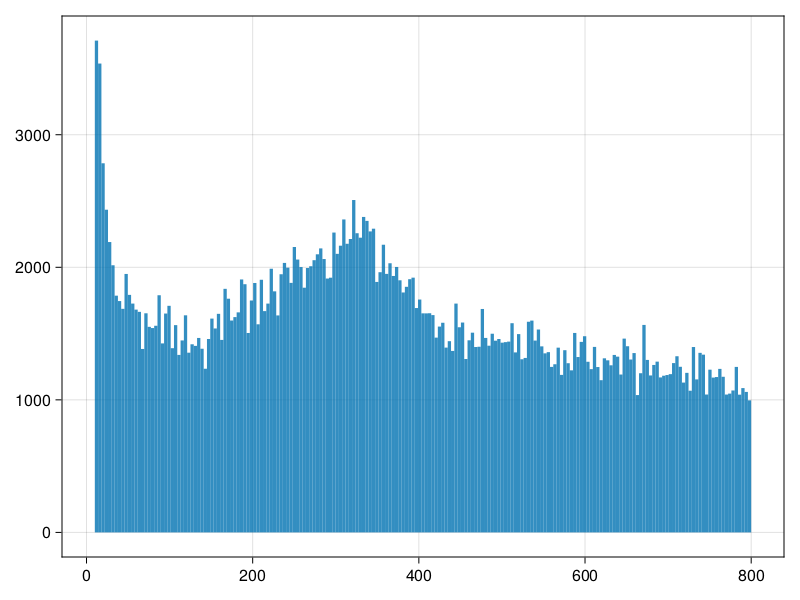

Couldn't fit 1200944 on index 1


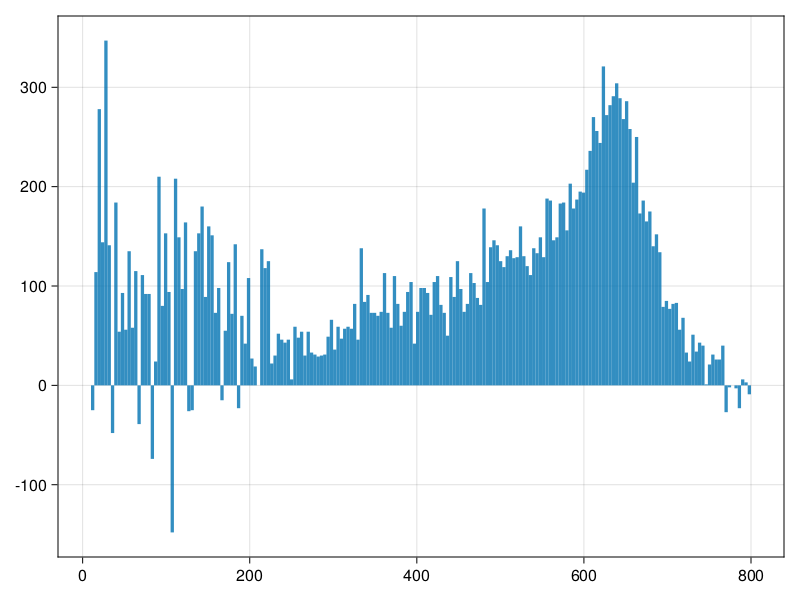

Couldn't fit 1405816 on index 5


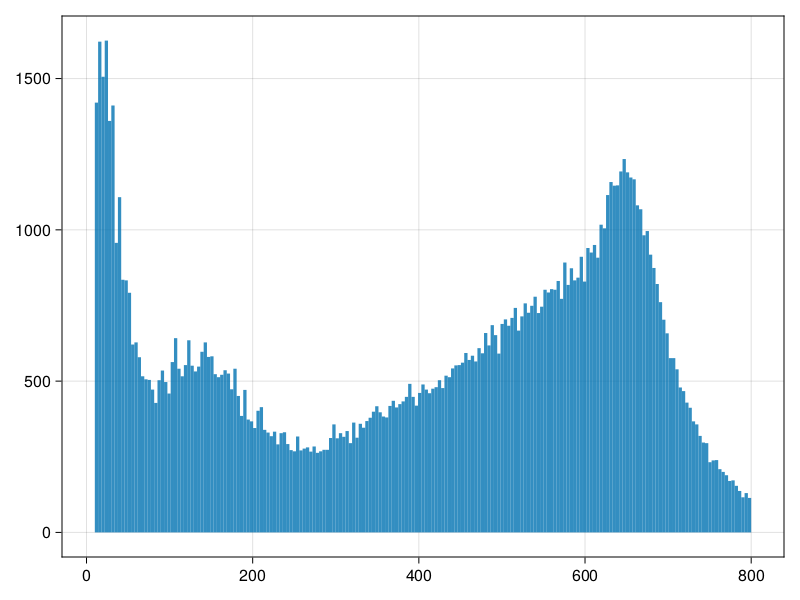

Couldn't fit 200735 on index 4


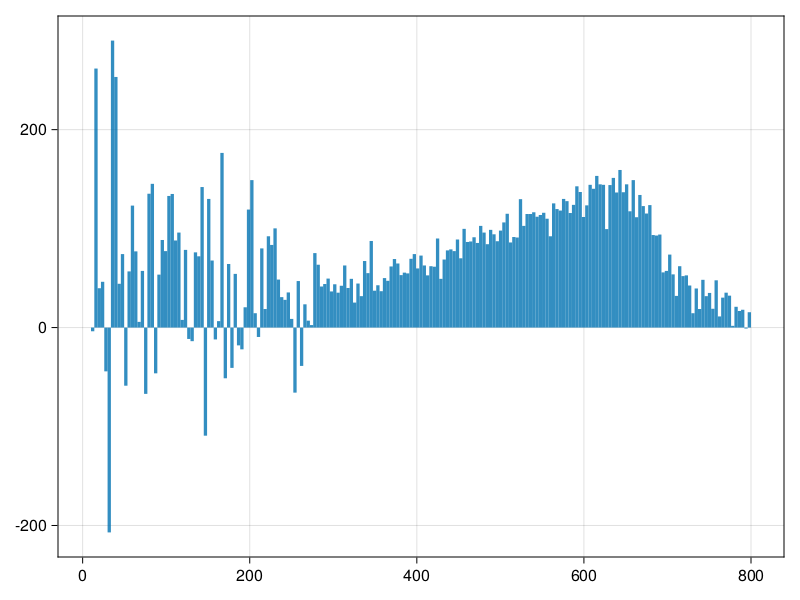

Couldn't fit 507730 on index 7


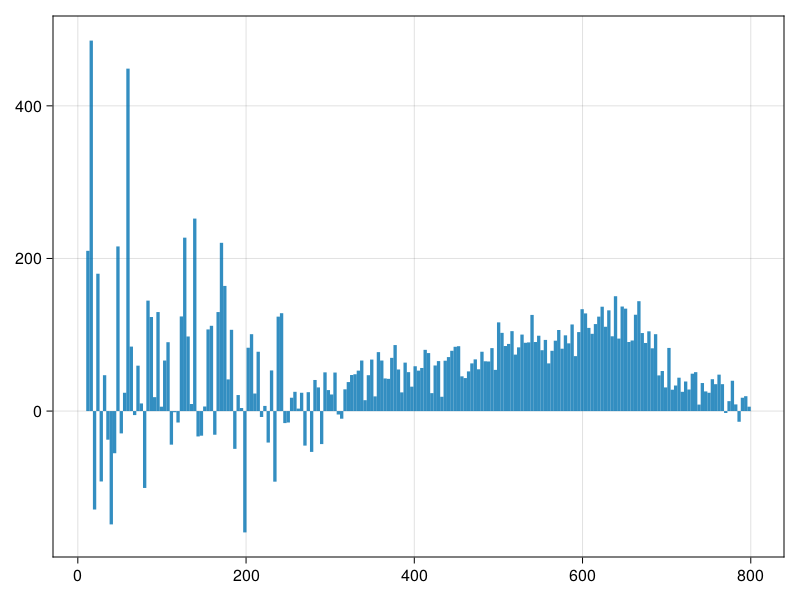

Couldn't fit 509637 on index 2


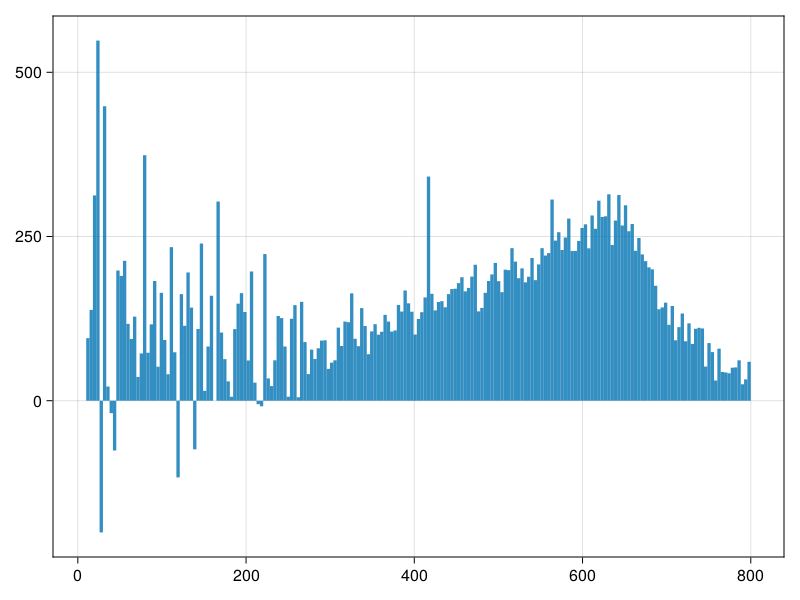

Couldn't fit 510488 on index 4


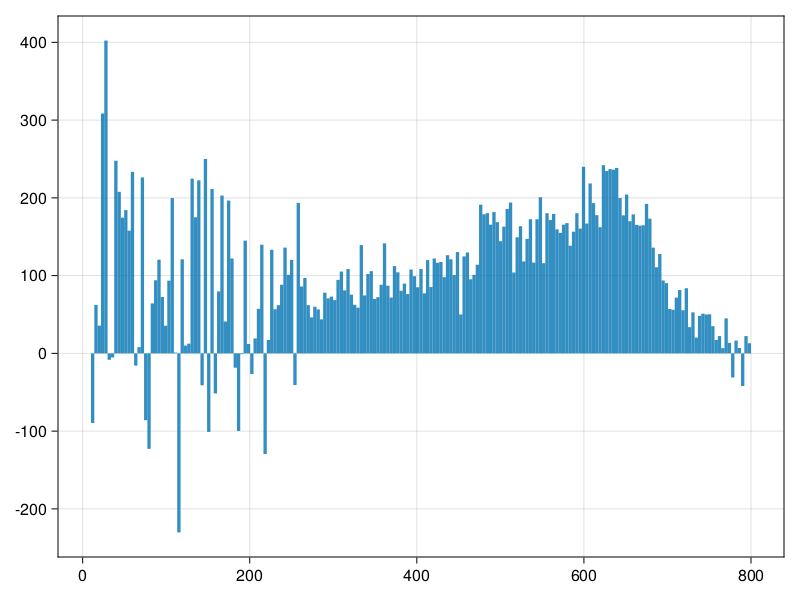

Couldn't fit 510965 on index 5


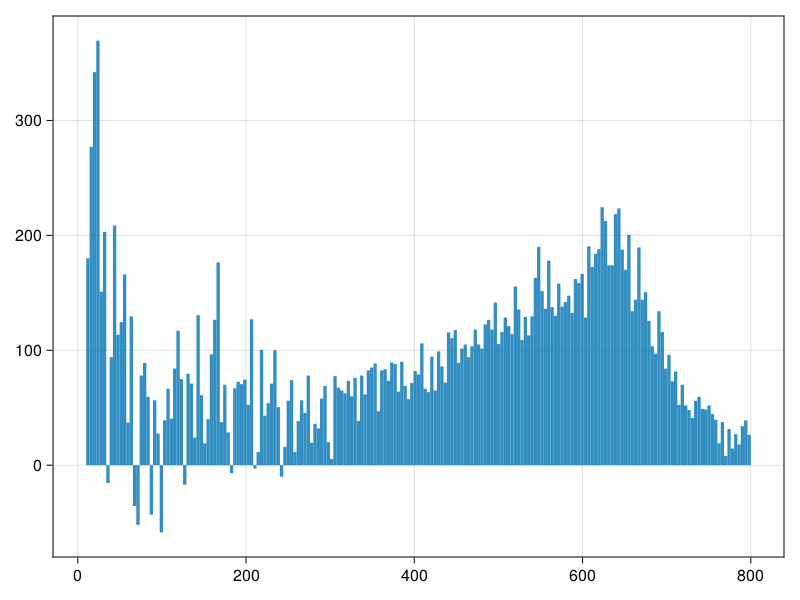

Couldn't fit 606435 on index 4


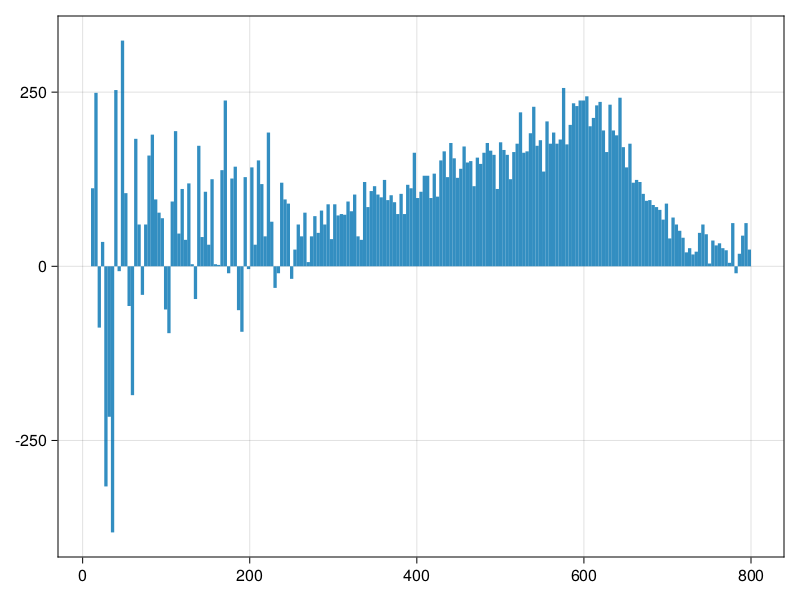

Couldn't fit 617394 on index 10


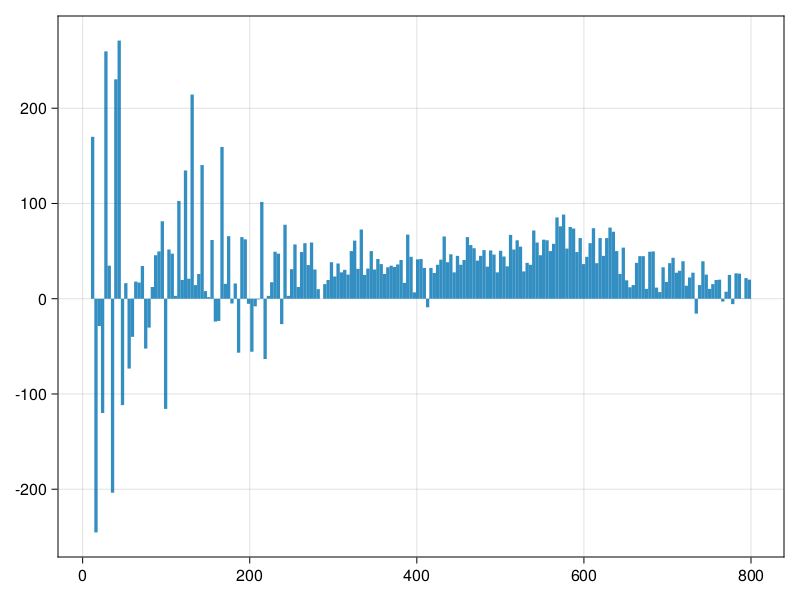

Couldn't fit 625394 on index 9


10×5 Matrix{Union{Missing, Float64}}:
      1.20094e6  1.68357e9  missing  missing  missing
      1.40582e6  1.69756e9  missing  missing  missing
 200735.0        1.52717e9  missing  missing  missing
 507730.0        1.57962e9  missing  missing  missing
 509637.0        1.58144e9  missing  missing  missing
 510488.0        1.58222e9  missing  missing  missing
 510965.0        1.58265e9  missing  missing  missing
 606435.0        1.59051e9  missing  missing  missing
 617394.0        1.59837e9  missing  missing  missing
 625394.0        1.60502e9  missing  missing  missing

In [17]:
cobalt_fl = readdir(datadir("exp_pro"); join=true)
cobalt_fl = filter(x -> occursin("Cobalt", x), cobalt_fl)
bkg_fl = readdir(datadir("exp_pro"); join=true)
bkg_fl = filter(x -> occursin("Bkg", x), bkg_fl)
bkg_rn = parse.(Int, (map(x -> x.match, match.(r"[0-9]+", bkg_fl))))
spe = readdlm(datadir("cal_results", "spe.txt"); comments=true)

results = Matrix{Union{Missing,Float64}}(undef, length(cobalt_fl), 5)
is = []
for (i, f) in enumerate(cobalt_fl)
  rf = ROOTFile(f)
  t = LazyTree(rf, "SimOut", ["adc1", "adc3", "f90", "timestamp", "runno"])

  run = t.runno[1]
  timestamp = t.timestamp[1]

  Δrun = abs.(bkg_rn .- run)
  close_bkg = bkg_fl[argmin(Δrun)]
  bkg_f = ROOTFile(close_bkg)
  bkgt = LazyTree(bkg_f, "SimOut", ["adc1", "adc3", "f90", "timestamp"])

  timestamp_bkg = bkgt.timestamp[1]

  adc1 = t.adc1 |> collect
  replace!(x -> x > 1e6 ? 0.0 : x, adc1) # replace bad samples
  adc3 = t.adc3 |> collect
  replace!(x -> x > 1e6 ? 0.0 : x, adc3) # replace bad samples
  f90 = t.f90 |> collect
  adc_bkg1 = bkgt.adc1 |> collect
  replace!(x -> x > 1e6 ? 0.0 : x, adc_bkg1) # replace bad samples
  adc_bkg3 = bkgt.adc3 |> collect
  replace!(x -> x > 1e6 ? 0.0 : x, adc_bkg3) # replace bad samples
  f90_bkg = bkgt.f90 |> collect

  speco_i = argmin(abs.(spe[:, 1] .- timestamp))
  spebkg_i = argmin(abs.(spe[:, 1] .- timestamp_bkg))
  speco1, speco3 = spe[speco_i, 2:3]
  spebkg1, spebkg3 = spe[spebkg_i, 2:3]

  # Run times for scaling
  co_time = t.timestamp[end] - t.timestamp[1]
  bkg_time = bkgt.timestamp[end] - bkgt.timestamp[1]

  npe_co = adc1 ./ speco1 .+ adc3 ./ speco3
  npe_bkg = adc_bkg1 ./ spebkg1 .+ adc_bkg3 ./ spebkg3
  if any(isnan, npe_co) || any(isnan, npe_bkg)
    results[i, :] .= run, timestamp, missing, missing, missing
    continue
  end

  # Ranges of possible LYs to search for
  yields = range(1.5, 5.5, length=40)
  bins = range(10, 800, length=200)
  co_hist = Hist1D(npe_co, bins)
  bkg_hist = Hist1D(npe_bkg, bins)

  data = co_hist - bkg_hist * (co_time / bkg_time)
  idx = argmax(bincounts(data))
  try
    x_fit = bincenters(data)[idx-10:idx+10]
    y_fit = bincounts(data)[idx-10:idx+10]
    peak_fit = curve_fit(parabola, x_fit, y_fit, [-0.5, 700.0, bins[idx]])
    a, b, c = coef(peak_fit)
    aerr, berr, cerr = stderror(peak_fit)
    results[i, :] .= run, timestamp, c / co_energy, cerr / co_energy, c
  catch
    println("Couldn't fit $run on index $idx")
    push!(is, i)
    fig, ax, h = hist(data)
    display(fig)
    results[i, :] .= run, timestamp, missing, missing, missing
    continue
  end
end
results[is, :]